Loading dataset: large_fake_job_postings.csv
Number of non-fraudulent (0) and fraudulent (1) job postings:
fraudulent
0    8051
1    1949
Name: count, dtype: int64

Percentage of fraudulent job postings: 19.49%
Preparing text data...
Vectorizing text data...
Creating additional features...
Normalizing features...
Balancing dataset...
Splitting dataset...

Training and evaluating Random Forest...
Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.47      0.49       402
           1       0.48      0.53      0.50       378

    accuracy                           0.50       780
   macro avg       0.50      0.50      0.50       780
weighted avg       0.50      0.50      0.50       780



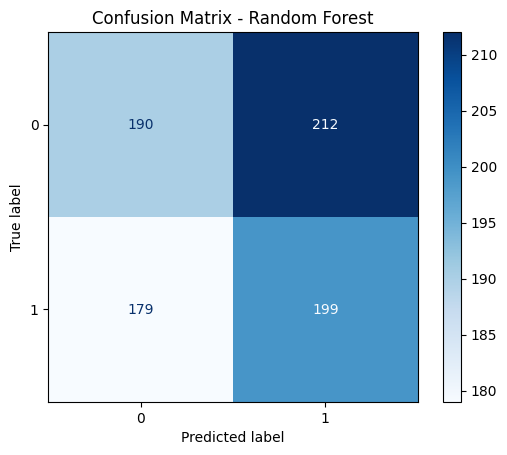

Cross-Validation F1 Scores: [0.48509485 0.51108214 0.51688312 0.49357326 0.50990753]
Mean F1 Score: 0.5033

Training and evaluating Logistic Regression...
Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.43      0.47       402
           1       0.48      0.55      0.51       378

    accuracy                           0.49       780
   macro avg       0.49      0.49      0.49       780
weighted avg       0.49      0.49      0.49       780



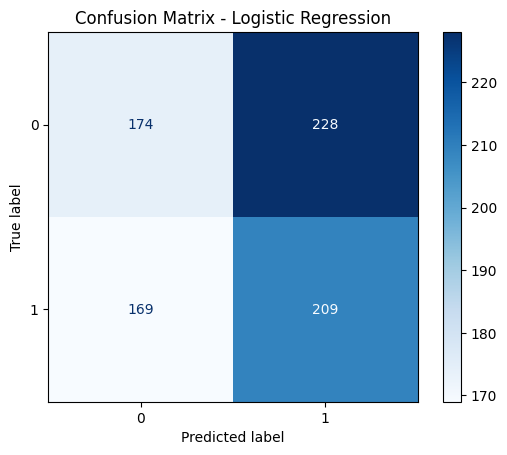

Cross-Validation F1 Scores: [0.48979592 0.49360614 0.5296343  0.505689   0.47908745]
Mean F1 Score: 0.4996

Training and evaluating Gradient Boosting...
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.50      0.52       402
           1       0.51      0.57      0.54       378

    accuracy                           0.53       780
   macro avg       0.53      0.53      0.53       780
weighted avg       0.53      0.53      0.53       780



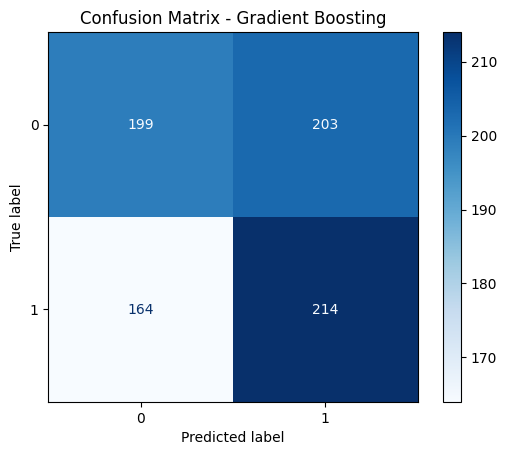

Cross-Validation F1 Scores: [0.51181102 0.49872774 0.5237484  0.505689   0.50722733]
Mean F1 Score: 0.5094

Training and evaluating SVM...
Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.51      0.51       402
           1       0.48      0.48      0.48       378

    accuracy                           0.50       780
   macro avg       0.50      0.50      0.50       780
weighted avg       0.50      0.50      0.50       780



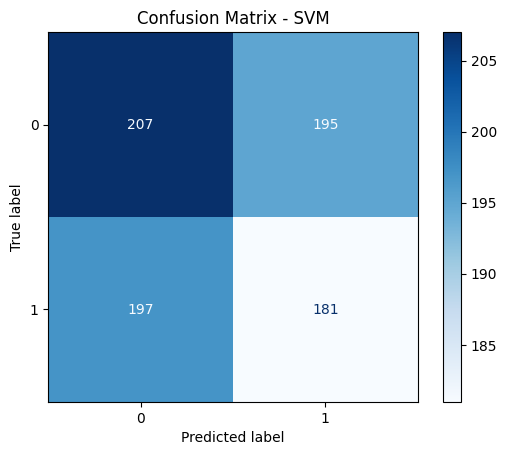

Cross-Validation F1 Scores: [0.49127517 0.48541114 0.5        0.48       0.47643979]
Mean F1 Score: 0.4866

Training and evaluating Naive Bayes...
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.54      0.53       402
           1       0.49      0.47      0.48       378

    accuracy                           0.51       780
   macro avg       0.51      0.51      0.51       780
weighted avg       0.51      0.51      0.51       780



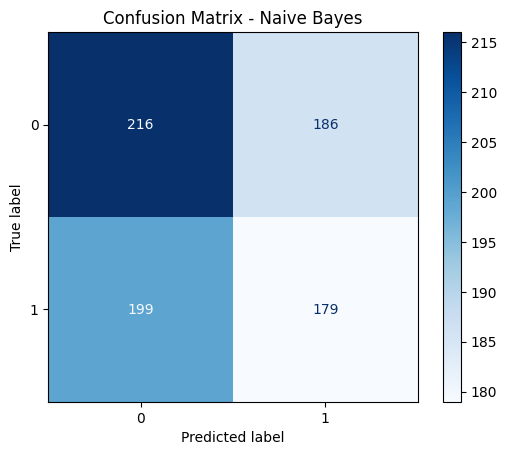

Cross-Validation F1 Scores: [0.48374512 0.50821745 0.5177665  0.47668394 0.5037594 ]
Mean F1 Score: 0.4980

Summary of Results:

Random Forest:
Mean F1 Score: 0.5033

Logistic Regression:
Mean F1 Score: 0.4996

Gradient Boosting:
Mean F1 Score: 0.5094

SVM:
Mean F1 Score: 0.4866

Naive Bayes:
Mean F1 Score: 0.4980


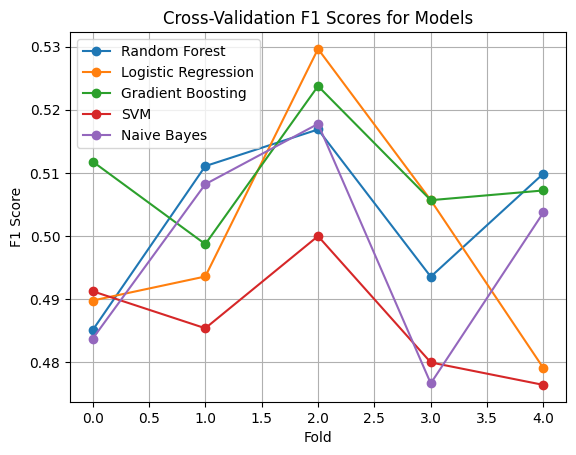

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample

# Try loading the dataset with various possible filenames
file_options = ["large_fake_job_postings.csv", "Fake Postings.csv", "fake Job_postings.csv"]
data = None

for file in file_options:
    if os.path.exists(file):
        print(f"Loading dataset: {file}")
        data = pd.read_csv(file)
        break

if data is None:
    raise FileNotFoundError("None of the specified dataset files were found.")

# Ensure the dataset has the required columns
required_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits', 'fraudulent']
for col in required_columns:
    if col not in data.columns:
        raise ValueError(f"Missing required column: {col}")

# Count and print the number of fraudulent and non-fraudulent job postings
fraudulent_counts = data['fraudulent'].value_counts()
print("Number of non-fraudulent (0) and fraudulent (1) job postings:")
print(fraudulent_counts)
print(f"\nPercentage of fraudulent job postings: {fraudulent_counts[1] / len(data) * 100:.2f}%")

# Combine text columns for feature extraction
print("Preparing text data...")
data['combined_text'] = data['title'].fillna('') + " " + \
                        data['company_profile'].fillna('') + " " + \
                        data['description'].fillna('') + " " + \
                        data['requirements'].fillna('') + " " + \
                        data['benefits'].fillna('')

# Vectorize text using TF-IDF
print("Vectorizing text data...")
tfidf = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1, 2))
X_text = tfidf.fit_transform(data['combined_text'])

# Create additional numerical features
print("Creating additional features...")
data['text_length'] = data['combined_text'].apply(len)
data['num_exclamation'] = data['combined_text'].apply(lambda x: x.count('!'))
data['num_question'] = data['combined_text'].apply(lambda x: x.count('?'))

# Combine TF-IDF features with numerical features
X_numerical = data[['text_length', 'num_exclamation', 'num_question']].values
X = np.hstack((X_text.toarray(), X_numerical))

# Target variable
y = data['fraudulent']

# Normalize numerical features
print("Normalizing features...")
scaler = MinMaxScaler()
X[:, -3:] = scaler.fit_transform(X[:, -3:])

# Separate majority and minority classes
X_majority = X[y == 0]
y_majority = y[y == 0]
X_minority = X[y == 1]
y_minority = y[y == 1]

# Undersample majority class
print("Balancing dataset...")
X_majority_undersampled, y_majority_undersampled = resample(X_majority, y_majority,
                                                            n_samples=len(X_minority),
                                                            random_state=42)

# Combine minority class with undersampled majority class
X_balanced = np.vstack((X_majority_undersampled, X_minority))
y_balanced = np.hstack((y_majority_undersampled, y_minority))

# Split dataset into training and testing sets
print("Splitting dataset...")
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Define classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, C=0.1, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42),
    "SVM": SVC(kernel='rbf', C=1, gamma='scale', random_state=42),
    "Naive Bayes": GaussianNB()
}

# Train and evaluate each classifier
results = {}
for name, clf in classifiers.items():
    print(f"\nTraining and evaluating {name}...")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Classification report
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    # Cross-Validation
    cv_scores = cross_val_score(clf, X_balanced, y_balanced, cv=5, scoring='f1')
    print("Cross-Validation F1 Scores:", cv_scores)
    print(f"Mean F1 Score: {cv_scores.mean():.4f}")

    # Store results
    results[name] = {
        "Classification Report": classification_report(y_test, y_pred, output_dict=True),
        "Confusion Matrix": cm,
        "Cross-Validation Scores": cv_scores
    }

# Summary of results
print("\nSummary of Results:")
for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"Mean F1 Score: {np.mean(metrics['Cross-Validation Scores']):.4f}")

    # Plot cross-validation scores
    plt.plot(metrics['Cross-Validation Scores'], marker='o', label=name)

plt.title("Cross-Validation F1 Scores for Models")
plt.xlabel("Fold")
plt.ylabel("F1 Score")
plt.legend()
plt.grid()
plt.show()
